# Using CMA-ME to Land a Lunar Lander Like a Space Shuttle

In [OpenAI Gym](https://gym.openai.com)'s [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment, an agent controls a spaceship to touch down gently within a goal zone near the bottom of the screen. Typically, agents in Lunar Lander take a direct approach, hovering straight down:

<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-vertical.mp4" type="video/mp4" /></video>

Of course, this works fine, and the lander safely landed on the landing pad. However, there are many (and more theatric) ways we can safely achieve our goal. For instance, a different solution is to land like a space shuttle:

<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-left.mp4" type="video/mp4" /></video>

And we can also approach from the right:

<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-right.mp4" type="video/mp4" /></video>

The primary difference between these trajectories is their "point of impact," that is, the $x$-position of the lander when one of its legs hits the ground for the first time. In the vertical trajectory, the lander first impacts the ground at $x \approx -0.1$, and when approaching from the left and right, it first impacts at $x \approx -0.5$ and $x \approx 0.6$, respectively.

Though these trajectories look different, they all achieve good performance (200+), leading to an interesting insight: there are characteristics of a lunar lander that are not necessarily important for performance, but nonetheless determine the behavior of the lander. In quality diversity (QD) terms, we call these behavior characteristics (BCs). In this tutorial, we will search for policies that yield different trajectories using the pyribs implementation of [CMA-ME](https://arxiv.org/abs/1912.02400).

## Setup

First, let's install pyribs and a specific version of OpenAI Gym.

In [ ]:
%pip install ribs[visualize] gym~=0.17.0 Box2D~=2.3.10 tqdm

Now we import OpenAI Gym and several utilities.

In [2]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Problem Description

We treat the Lunar Lander as a quality diversity (QD) problem. For the objective, we use the default rewards provided by OpenAI gym, which encourages landing on the landing pad and penalizes engine usage.

For the behavior characteristics (BCs), we are interested in several factors at the time of "impact." We define impact to be the first time when either of the lunar lander's legs touches the ground. When this happens, we measure the following:

- $x$-position: This will lead to markedly different trajectories, as seen earlier.
- $y$-velocity: Different velocities will determine how hard the lander impacts the ground.

If the lunar lander never impacts the ground, we default the $x$-position to be the last $x$-position of the lander, and the $y$-velocity to be the maximum velocity of the lander (technically minimum since velocities are negative).

We will search for policies that produce high-performing trajectories with these characteristics. For simplicity, we will use a linear policy to control the lunar lander. As the default lunar lander has discrete controls, the equation for this policy is:

$$a = argmax(Ws)$$

where $a$ is the action to take, $s$ is the state vector, and $W$ is our model, a matrix of weights that stays constant. Essentially, we transform the state to a vector with a "signal" for each possible action in the action space, and we choose the action with the highest signal. To search for a different policy, we explore the space of models $W$.

In this tutorial, we will search for policies solving a fixed scenario with a flat terrain. To create this scenario, we use a fixed seed of 1339 in the environment.

**Note:** Since our policy and environment are both deterministic, we only have to simulate the policy once to find its performance. Typically, we would run our policy multiple times to gauge average performance and have it generalize, but we ignore that to keep this example simple.

In [3]:
env = gym.make("LunarLander-v2")
seed = 1339
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0]

We can summarize our problem description with the following `simulate` function, which takes in the model and simulates it in the Lunar Lander environment.

In [4]:
def simulate(env, model, seed=None):
    """Simulates the lunar lander model.

    Args:
        env (gym.Env): A copy of the lunar lander environment.
        model (np.ndarray): The array of weights for the linear policy.
        seed (int): The seed for the environment.
    Returns:
        total_reward (float): The reward accrued by the lander throughout its
            trajectory.
        impact_x_pos (float): The x position of the lander when it touches the
            ground for the first time.
        impact_y_vel (float): The y velocity of the lander when it touches the
            ground for the first time.
    """
    if seed is not None:
        env.seed(seed)

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = model.reshape((action_dim, obs_dim))

    total_reward = 0.0
    impact_x_pos = None
    impact_y_vel = None
    all_y_vels = []
    obs = env.reset()
    done = False

    while not done:
        action = np.argmax(model @ obs)  # Linear policy.
        obs, reward, done, info = env.step(action)
        total_reward += reward

        # Refer to the definition of state here:
        # https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L306
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])
        all_y_vels.append(y_vel)

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel

    # If the lunar lander did not land, set the x-pos to the one from the final
    # timestep, and set the y-vel to the max y-vel (we use min since the lander
    # goes down).
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = min(all_y_vels)

    return total_reward, impact_x_pos, impact_y_vel

## CMA-ME with pyribs

To train our policy, we will use the CMA-ME algorithm. This means we need to import and initialize the `GridArchive`, `ImprovementEmitter`, and `Optimizer` from pyribs.

First, the `GridArchive` stores solutions (i.e. models for our policy) in a rectangular grid. Each dimension of the `GridArchive` corresponds to a dimension in behavior space that is segmented into equally sized bins. As we have two BCs for our lunar lander, we have two dimensions in the `GridArchive`. The first dimension is the impact $x$-position, which ranges from -1 to 1, and the second is the impact $y$-velocity, which ranges from -3 (smashing into the ground) to 0 (gently touching down). We divide both BCs into 50 bins.

In [5]:
from ribs.archives import GridArchive

archive = GridArchive(
    [50, 50],  # 50 bins in each dimension.
    [(-1.0, 1.0), (-3.0, 0.0)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
)

Next, the `ImprovementEmitter` uses CMA-ES to search for policies that add new entries to the archive or improve existing ones. Since we do not have any prior knowledge of what the model will be, we set the initial model to be the zero vector, and we set the initial step size for CMA-ES to be 1.0, so that initial solutions are sampled from an isotropic Gaussian. Furthermore, we use 5 emitters so the algorithm simultaneously searches several areas of behavior space.

**Note:** Below, we specify a batch size of 30, but if we do not specify a batch size, the `ImprovementEmitter` will automatically use a batch size equal to the default population size of CMA-ES.

In [6]:
from ribs.emitters import ImprovementEmitter

initial_model = np.zeros((action_dim, obs_dim))
emitters = [
    ImprovementEmitter(
        archive,
        initial_model.flatten(),
        1.0,  # Initial step size.
        batch_size=30,
    ) for _ in range(5)  # Create 5 separate emitters.
]

Finally, the ``Optimizer`` connects the archive and emitters together.

In [7]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

## QD Search

With the pyribs components defined, we start searching with CMA-ME. This loop should take 2-4 hours to run. Since we use 5 emitters each with a batch size of 30 and we run 500 iterations, we run 5 x 30 x 500 = 75,000 lunar lander simulations. We also keep track of some logging info.

In [8]:
start_time = time.time()
total_itrs = 500

for itr in tqdm(range(1, total_itrs + 1)):
    # Request models from the optimizer.
    sols = optimizer.ask()

    # Evaluate the models and record the objectives and BCs.
    objs, bcs = [], []
    for model in sols:
        obj, impact_x_pos, impact_y_vel = simulate(env, model, seed)
        objs.append(obj)
        bcs.append([impact_x_pos, impact_y_vel])

    # Send the results back to the optimizer.
    optimizer.tell(objs, bcs)

    # Logging.
    if itr % 25 == 0:
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time:.2f} s")
        print(f"  - Archive Size: {len(archive)}")
        print(f"  - Max Score: {archive.stats.obj_max}")

> 25 itrs completed after 266.94 s
  - Archive Size: 1182
  - Max Score: 272.7421352549696
> 50 itrs completed after 489.73 s
  - Archive Size: 1663
  - Max Score: 272.7421352549696
> 75 itrs completed after 838.56 s
  - Archive Size: 2020
  - Max Score: 272.7421352549696
> 100 itrs completed after 1351.47 s
  - Archive Size: 2231
  - Max Score: 272.7421352549696
> 125 itrs completed after 1687.66 s
  - Archive Size: 2385
  - Max Score: 276.02389607126
> 150 itrs completed after 1936.20 s
  - Archive Size: 2436
  - Max Score: 276.02389607126
> 175 itrs completed after 2229.05 s
  - Archive Size: 2474
  - Max Score: 278.1174952325839
> 200 itrs completed after 2617.76 s
  - Archive Size: 2487
  - Max Score: 283.16044592054885
> 225 itrs completed after 2915.54 s
  - Archive Size: 2494
  - Max Score: 283.16044592054885
> 250 itrs completed after 3303.96 s
  - Archive Size: 2497
  - Max Score: 283.16044592054885
> 275 itrs completed after 4110.25 s
  - Archive Size: 2498
  - Max Score: 28

## Visualizing the Archive

Using `grid_archive_heatmap` from `ribs.visualize`, we can view a heatmap of the archive. The heatmap shows the BCs for which CMA-ME found a solution. The color of each cell shows the objective value of the solution.

Text(0.5, 0, 'Impact x-position')

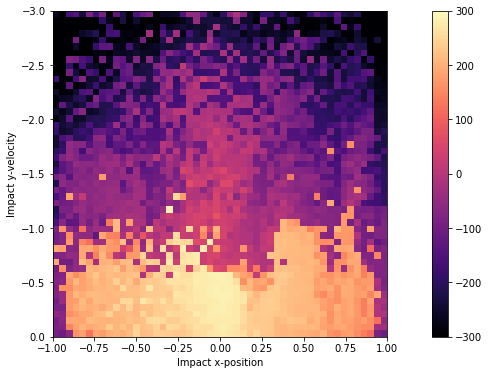

In [9]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.gca().invert_yaxis()  # Makes more sense if larger velocities are on top.
plt.ylabel("Impact y-velocity")
plt.xlabel("Impact x-position")

From this heatmap, we can make a few observations:

- CMA-ME found solutions for almost all bins in the archive. Empty bins show up as white.
- Most of the high-performing solutions have lower impact $y$-velocities (see the bright area at the bottom of the map). This is reasonable, as a lander that crashes into the ground probably would not stick the landing.
- The high-performing solutions are spread across a wide range of impact $x$-positions. The highest solutions seem to be at $x \approx 0$ (the bright spot in the middle). This makes sense since an impact $x$-position of 0 corresponds to the direct vertical approach. Nevertheless, there are many high-performing solutions that had other $x$-positions, and we will visualize them in the next section.

## Visualizing Individual Trajectories

To view the trajectories for different models, we can use the OpenAI Gym Monitor to record a video, and we can use IPython to display the video in the notebook. The `display_video` function shows how to do this.

In [10]:
try:
    # In Google Colab, it is necessary to set up a virtual display so that
    # OpenAI Gym can render properly.

    import google.colab
    print("Google Colab detected. Setting up virtual display.")

    !apt-get install -y xvfb python-opengl
    %pip install pyvirtualdisplay

    from pyvirtualdisplay import Display

    display = Display(visible=0, size=(400, 300))
    display.start()
except ImportError:
    print("Not in Google Colab. Skipping display setup.")

Not in Google Colab. Skipping display setup.


In [11]:
import base64
import glob
import io

from IPython.display import display, HTML


def display_video(model):
    """Displays a video of the model in the environment."""

    # Monitor records a video of the environment.
    video_env = gym.wrappers.Monitor(
        gym.make("LunarLander-v2"),
        "videos",  # Video directory.
        force=True,  # Overwrite existing videos.
        video_callable=lambda idx: True,  # Make all episodes be recorded.
    )
    simulate(video_env, model, seed)
    video_env.close()  # Save video.

    # Display the video with HTML. Though we use glob, there is only 1 video.
    for video_file in glob.glob("videos/*.mp4"):
        video = io.open(video_file, 'rb').read()
        encoded = base64.b64encode(video).decode("ascii")
        display(
            HTML(f'''
            <video width="360" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>'''))

Using the ``elite_with_behavior`` method on the archive, we can retrieve policies with BCs that are close to a query. First, we retrieve a policy that impacted the ground on the left (approximately -0.4) with low velocity (approximately -0.10).

In [12]:
elite = archive.elite_with_behavior([-0.4, -0.10])
if elite.sol is not None:
    display_video(elite.sol)

We can also find a policy that impacted the ground on the right (0.4) with low velocity.

In [13]:
elite = archive.elite_with_behavior([0.4, -0.10])
if elite.sol is not None:
    display_video(elite.sol)

And we can find a policy that executes a regular vertical landing, which happens when the impact $x$-position is around 0.

In [14]:
elite = archive.elite_with_behavior([0.0, -0.10])
if elite.sol is not None:
    display_video(elite.sol)

As the archive has ~2500 solutions, we cannot view them all, but we can filter for high-performing solutions. We choose solutions that scored above 200 because 200 is the threshold for the problem to be considered [solved](http://gym.openai.com/envs/LunarLander-v2/). Note that many solutions that are considered solved do not land on the landing pad.

In [15]:
df = archive.as_pandas()
high_perf_sols = df.query("objective > 200").sort_values("objective", ascending=False)

Below we visualize several of these high-performing solutions.

In [16]:
if len(high_perf_sols) > 0:
    for elite in high_perf_sols.iloc[[0, len(high_perf_sols) // 2, -1]].iterelites():
        display_video(elite.sol)

## Conclusion

As the saying goes, "there is more than one way to land an airplane" 😉. However, it is often difficult to shape the reward function in reinforcement learning to discover these unique and "creative" solutions. In such cases, a QD algorithm can help search for solutions that vary in "interestingness."

In this tutorial, we showed that this is the case for the lunar lander environment. Using CMA-ME, we searched for lunar lander trajectories with differing impact characteristics. Though these trajectories all take a different approach, many perform well.

For extending this tutorial, we suggest the following:

- Replace the impact characteristics with your own BCs. What other properties might be interesting for the lunar lander?
- Try different terrains by changing the seed. For instance, if the environment has valleys, can the lander learn to go into this valley and glide back up?
- Use other gym environments. What BCs could you use in an environment like `BipedalWalker-v2`?

Finally, for a version of this tutorial that uses [Dask](https://dask.org) to parallelize evaluations and thus speed things up, refer to the Lunar Lander [example](https://docs.pyribs.org/en/stable/examples/lunar_lander.html).

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_lunar_lander,
  title   = {Using CMA-ME to Land a Lunar Lander Like a Space Shuttle},
  author  = {Bryon Tjanaka and Sam Sommerer and Nikitas Klapsis and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2021},
  url     = {https://docs.pyribs.org/en/stable/tutorials/lunar_lander.html}
}
```

## Credits

This tutorial is based on a [poster](https://1l7puj10vwe3zflo2jsktkit-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/S20-Klapsis-Poster.pdf) created by Nikitas Klapsis as part of USC's 2020 SHINE program.